# Milestone 2: Project proposal and initial analyses

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**, following several definitions.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import ast 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import statsmodels.api as sm

## 1. Exploration of the dataset

Many variables of the dataset are relevant to predict the success of an actor or an actress. Some are present in the characters dataset:
- Age at the beginning of their careers
- Age at the time of the movie
- Gender
- Ethnicity
- Height

Some are present in the movie dataset, but would need to be aggregated by actor:
- Movie release date (relative to the first film?): maybe some actors released their average movie during the golden age of the film industry?
- Movie language: maybe some languages allow to touch more people?
- Country of the movie: the country with the most occurence?

Some have to be constructed for this analysis:
- Variety of film genres in which the actor has played
- Variety of roles portrayed with an analysis of personas

### Movies metadata

In [5]:
movies = pd.read_table('./Data/MovieSummaries/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
display(movies)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


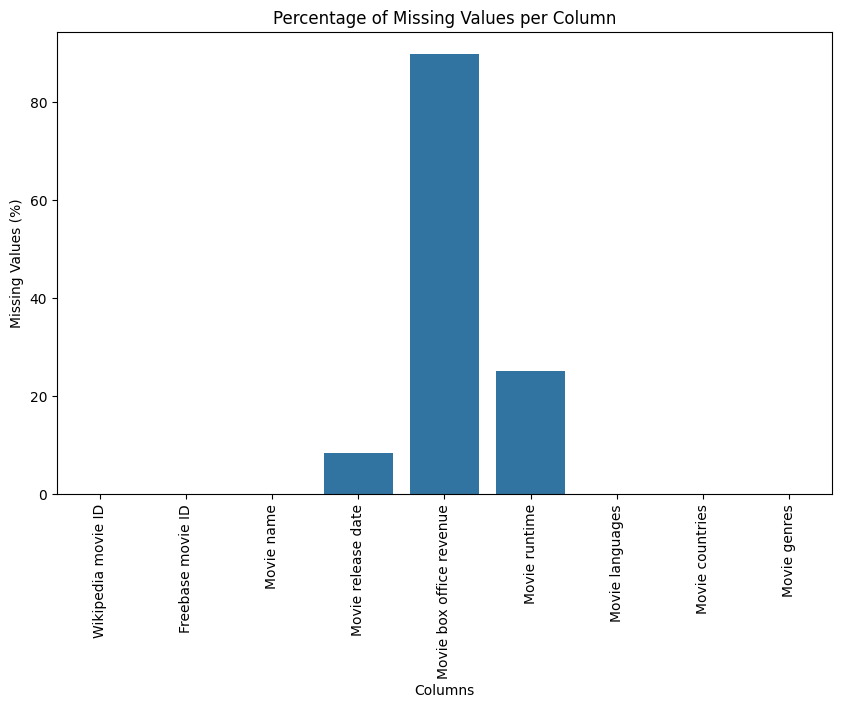

In [6]:
# Count missing values per column
missing_percent = (movies.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

# How will we deal with the large share of missing values for a key feature?

In [10]:
# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

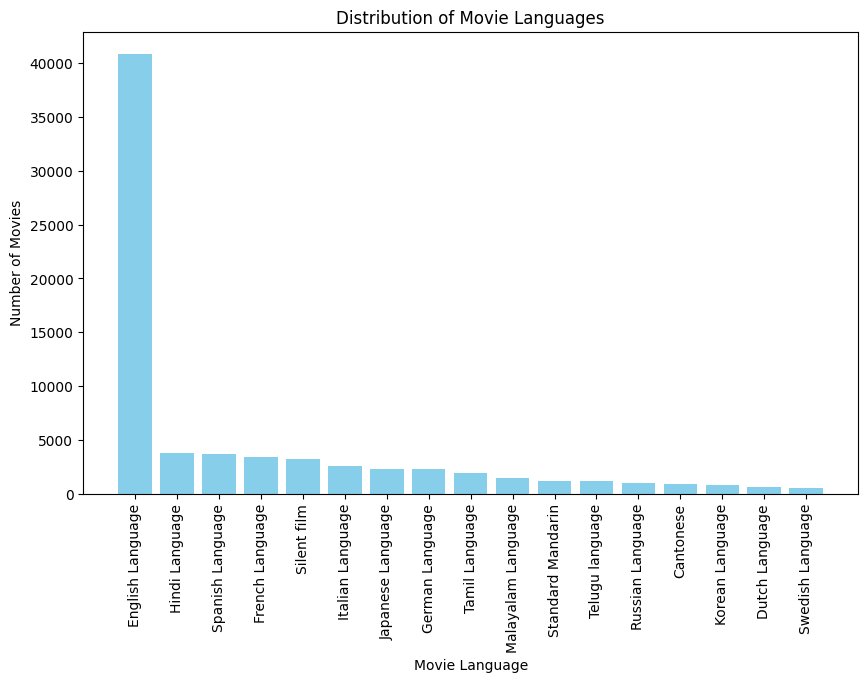

In [11]:
# Flatten the dictionaries and count language occurrences
language_counts = Counter(language for languages_dict in movies["Movie languages"] for language in languages_dict.values())

# Filter the language counts for readability
filtered_language_counts = {language: count for language, count in language_counts.items() if count > 500}
sorted_filtered_language_counts = dict(sorted(filtered_language_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
languages, counts = zip(*sorted_filtered_language_counts.items())
plt.bar(languages, counts, color='skyblue')
plt.xlabel('Movie Language')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Languages')
plt.xticks(rotation=90)  
plt.show()

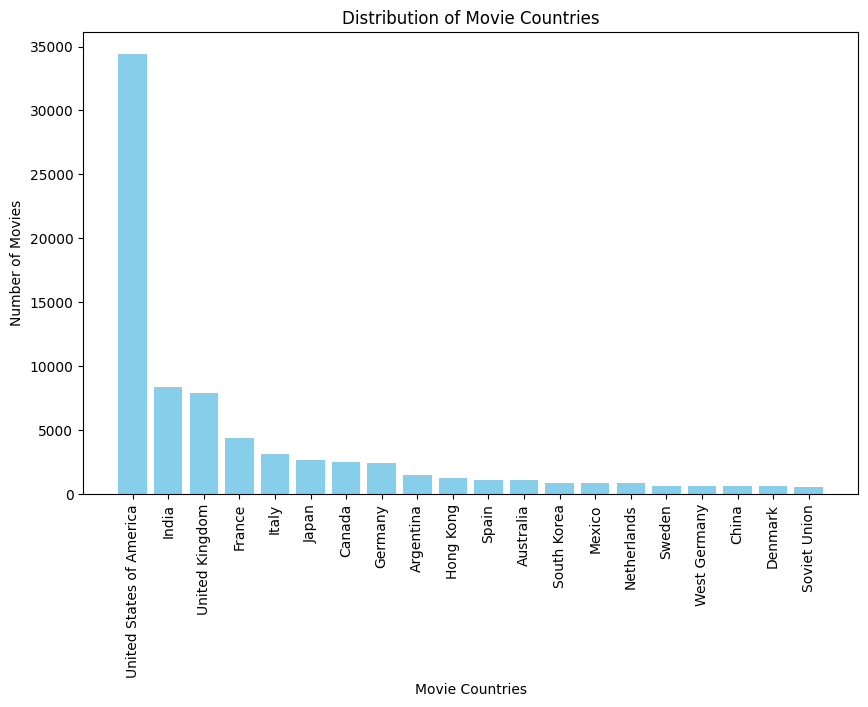

In [12]:
# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in movies["Movie countries"] for country in countries_dict.values())

# Filter the language counts for readability
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_filtered_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
countries, counts = zip(*sorted_filtered_countries_counts.items())
plt.bar(countries, counts, color='skyblue')
plt.xlabel('Movie Countries')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Countries')
plt.xticks(rotation=90)  
plt.show()

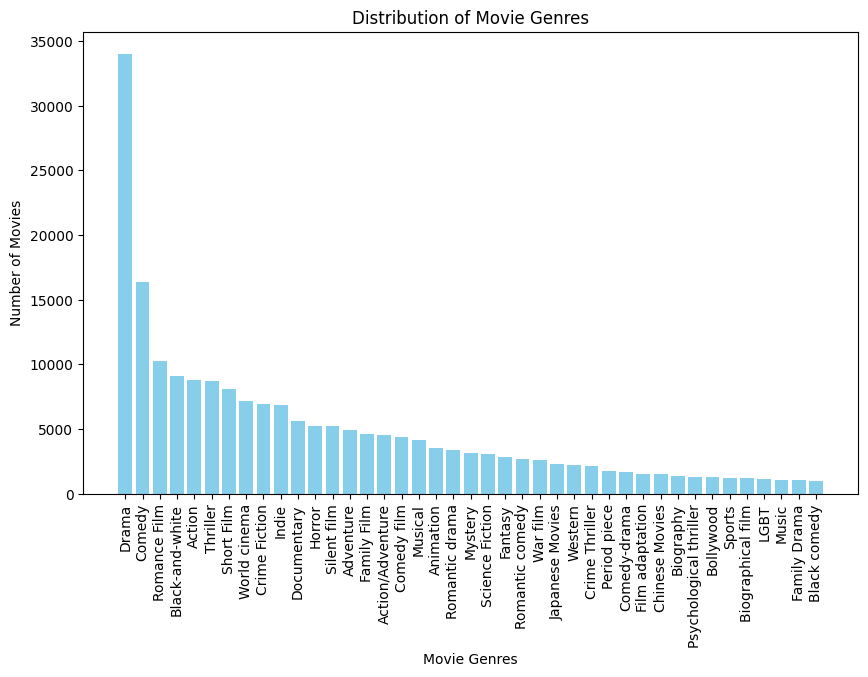

In [13]:
# Flatten the dictionaries and count countries occurrences
genres_counts = Counter(genre for genres_dict in movies["Movie genres"] for genre in genres_dict.values())

# Filter the language counts for readability
filtered_genres_counts = {genre: count for genre, count in genres_counts.items() if count > 1000}
sorted_filtered_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
genres, counts = zip(*sorted_filtered_genres_counts.items())
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

### Characters metadata

In [20]:
characters = pd.read_table('./Data/MovieSummaries/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
display(characters)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


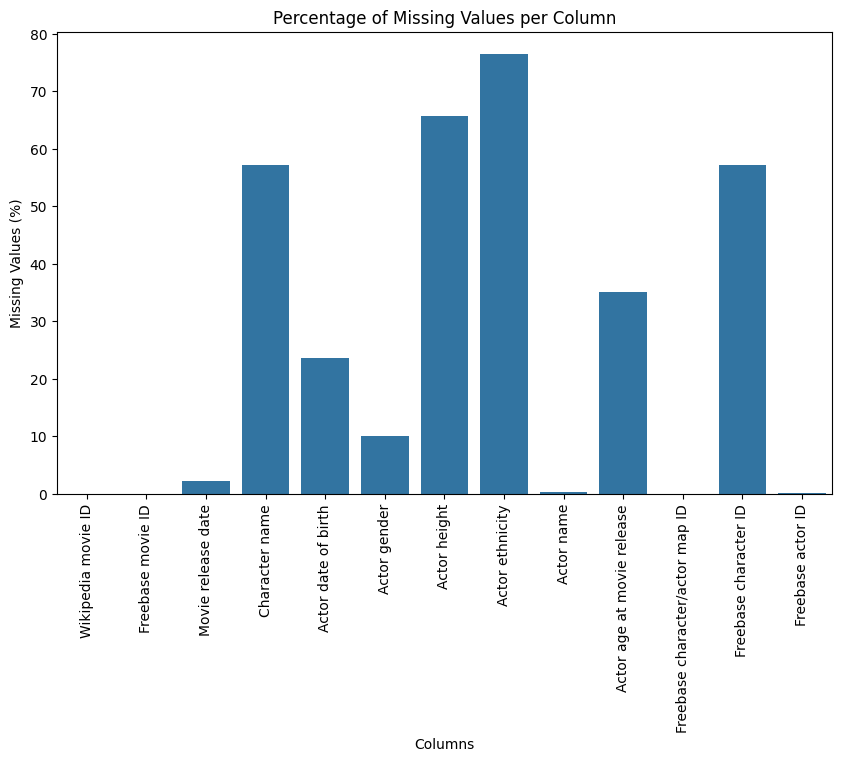

In [21]:
# Count missing values per column
missing_percent = (characters.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

## 2. Complementary datasets and initial analyses

The success can be characterized based on several factors, including:
- Longevity
- Number of movies played
- IMDB ratings
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 2.1 [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [26]:
oscars = pd.read_csv('./Data/oscar_awards.csv')
display(oscars)

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
11053,2017,SCIENTIFIC AND TECHNICAL AWARD (Scientific and...,True,"To LEONARD CHAPMAN for the overall concept, de..."
11054,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To JASON SMITH and JEFF WHITE for the original...
11055,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,"To JOE MANCEWICZ, MATT DERKSEN and HANS RIJPKE..."
11056,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To ALEX POWELL for his contribution to the des...


In [27]:
actors_oscars = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]
display(actors_oscars) 

# Until 1975, there was only one category for actors and one for actresses. 
# Nowadays, there are leading and supporting categories, so twice as many nominees each year.

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
10935,2017,ACTRESS IN A SUPPORTING ROLE,False,Mary J. Blige
10936,2017,ACTRESS IN A SUPPORTING ROLE,True,Allison Janney
10937,2017,ACTRESS IN A SUPPORTING ROLE,False,Lesley Manville
10938,2017,ACTRESS IN A SUPPORTING ROLE,False,Laurie Metcalf


In [30]:
characters_oscars = characters.merge(actors_oscars, left_on='Actor name', right_on='entity', how='left')

characters_oscars['entity'].isna().sum() # 418049
characters_oscars.shape[0] # 489192

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))
# How many nominees don't appear in the dataset?

There are 14.31% of Oscar nominees or winners in the movies dataset.


### Limitations of the dataset

The Oscars take place in the US and are usually political. It is less likely for popular foreign actors to win an award outside the best international film category, even if some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

We haven't found an exhaustive dataset of awards. We might decide to extend the analysis to more award ceremonies but none is exempt from this national preference: The Australian Film Institute Awards, The BAFTA Film Awards (UK), the Césars Film Awards (France), the Golden Bears (Germany), the Golden Globes (US), the Golden Lions (Venice), the Palme d'Or awards (France), the Sundance Film Festival awards (independent movies), Filmfare (Hindi), etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of actors outside of Hollywood.

In [31]:
# What are movie nationalities of actors that won an Oscar?

characters_oscars_movies = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

In [32]:
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts
# A lot of countries are represented, but the US is still largely above the rest.

{'United States of America': 34408,
 'India': 8411,
 'United Kingdom': 7868,
 'France': 4395,
 'Italy': 3163,
 'Japan': 2647,
 'Canada': 2534,
 'Germany': 2393,
 'Argentina': 1468,
 'Hong Kong': 1240,
 'Spain': 1136,
 'Australia': 1114,
 'South Korea': 887,
 'Mexico': 870,
 'Netherlands': 840,
 'Sweden': 657,
 'West Germany': 647,
 'China': 645,
 'Denmark': 610,
 'Soviet Union': 564}

### Initial analyses

**Predicting oscars with character metadata**

In [33]:
## Prepare the features vector for training ##

# Choose the relevant features
actors_features = ['Movie release date', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity']

X = characters_oscars[actors_features].copy()

# Removing missing values, for now imputations don't make sense here. 
# But because of ethnicity and height we get rid of a lot of observations
X_ = X[~(X.isna().any(axis=1))].copy()
len(X_[X_.isna().any(axis=1)])

X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

# Compute the number of days away from the first movie
X_.loc[:, 'release date'] = pd.to_datetime(X_['Movie release date'], format='mixed') # convert release date into date format 
X_['release date'] = (X_['release date'] - X_['release date'].min()).dt.days # and then into int

gender_mapping = {'F': 1, 'M': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping) # Use a mapping to convert the 'gender' column to float

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the categorical variable and transform it
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

X_ = X_.drop('Movie release date', axis=1)
X_ = X_.drop('Actor ethnicity', axis=1)

In [34]:
display(X_)

,Actor gender,Actor age at movie release,Actor height,release date,Encoded ethnicity
1,1,27.0,1.780,33838,139
2,2,32.0,1.727,33838,351
5,1,52.0,1.727,33838,351
55,2,31.0,1.630,35429,135
56,2,34.0,1.870,35429,99
...,...,...,...,...,...
488400,2,21.0,1.790,15705,352
488404,1,30.0,1.746,32572,99
488416,1,21.0,1.720,33968,135
488417,2,55.0,1.740,33968,135


In [35]:
## Prepare the outcome vector for training ##

# We want integers as outcomes
outcome_mapping = {0: 'is nominated for an Oscar', 1: 'wins an Oscar', 2: 'gets nothing'}

characters_oscars.loc[characters_oscars['winner'].isna(), 'winner'] = 2 # missing values mean not winner nor nominated
y = characters_oscars['winner'].astype('int')

# We remove the same observations as for the features vector
y_ = y[~(X.isna().any(axis=1))]

In [36]:
display(y_)

1         2
2         2
5         2
55        2
56        2
         ..
488400    2
488404    2
488416    2
488417    2
488439    2
Name: winner, Length: 86640, dtype: int32

In [37]:
## Training ##

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      5341
           1       0.34      0.22      0.26      1519
           2       0.98      0.99      0.99     10468

    accuracy                           0.88     17328
   macro avg       0.70      0.69      0.69     17328
weighted avg       0.87      0.88      0.87     17328



In [38]:
## Prediction of oscars based on an input vector of features ##

predicted_label = model.predict([[1,43,30000, 180, 120]])[0] # we need a mapping of ethnicities to interpret it
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

This actor/actress gets nothing.


C:\Users\malou\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Next step: Analyze feature importance and add more features.
We should make sure to keep only movies that took place before the Oscar, as predicting an Oscar with movie characteristics such as release date post-Oscar doesn't make sense. Moreover, we can associate the Oscar with a specific movie, as it is not the entire career being awarded. 

## 2.2 Cumulated revenues of movies

In [1]:
movies_revenues = movies['Movie box office revenue'].dropna().copy()

# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_revenues, kde=False, bins=100)
plt.xlabel('Movie box office revenue')
plt.ylabel('Frequency (log)')
plt.title('Distribution of movie box office revenue')
plt.yscale("log")
plt.show()

NameError: name 'movies' is not defined

### Limitations

Someone can play an unimportant role in many high revenues movies, it doesn't mean they are getting a lot of income from their movie. However, combined with other indicators, it can give us an idea of the success of someone. Note that we do not establish a causal relationship between the presence of an actor and the money the movie generated.

### Initial analyses

In [41]:
actors_movies = characters.merge(movies, on='Freebase movie ID', how='left') 

# Compute the number of days away from the first movie
actors_movies.loc[:, 'release date'] = pd.to_datetime(actors_movies['Movie release date_x'], format='mixed', errors = 'coerce') # convert release date into date format 
actors_movies['release date'] = (actors_movies['release date'] - actors_movies['release date'].min()).dt.days # and then into int

In [42]:
actors_revenues = actors_movies.groupby('Actor name')

# Custom aggregation function to get lists of unique values
unique_list = lambda x: len(list(set(val for sublist in x for val in sublist)))

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Movie box office revenue': 'sum',
    'Movie name': 'nunique',
    'Movie countries': unique_list,
    'Movie genres': unique_list,
    'Movie languages': unique_list,
    'Actor age at movie release': 'mean',
    'release date': 'mean'
}).reset_index()

# Renaming the columns for clarity
actor_statistics.columns = ['actor_name', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages', 'mean_age', 'mean_release'] 
                            
# Displaying the resulting DataFrame
display(actor_statistics) # problem with zero revenues to solve

,actor_name,total_revenues,unique_movies,unique_countries,unique_genres,unique_languages,mean_age,mean_release
0,Cesarine Prinz\t,0.0,2,1,2,0,NaN,13406.50
1,Daniel Newman,0.0,1,3,2,1,22.000000,40485.00
2,'Big Bill' Giddinger,0.0,1,1,5,1,NaN,8544.00
3,'Big' Lee,0.0,1,1,3,1,NaN,31251.00
4,'Chicken' Holleman,0.0,1,1,7,1,NaN,30845.00
...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,0.0,1,1,4,1,22.000000,42423.00
134074,雪乃五月,0.0,2,1,6,1,30.500000,41455.50
134075,高山久子,0.0,3,1,12,1,35.333333,40006.00
134076,高橋美紀,0.0,1,1,2,1,24.000000,35794.00


In [43]:
actors_movies = actors_movies.merge(actor_statistics, left_on='Actor name', right_on='actor_name')

In [44]:
## Naive linear regression ##

df = actors_movies.copy()

gender_mapping = {'F': 1, 'M': 2}
df['Actor gender'] = df['Actor gender'].map(gender_mapping)

# Adding a constant for the intercept term in the regression
df = sm.add_constant(df)

df = df[['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']]
print(df.shape)
df = df.dropna() # have to find an alternative, we lose over 70% of the data
print(df.shape)

# Defining the independent variables
independent_vars = ['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']

(449441, 10)
(147101, 10)


In [45]:
# Creating the model
model = sm.OLS(df['total_revenues'], df[independent_vars])

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         total_revenues   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.474e+04
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:21:41   Log-Likelihood:            -3.2697e+06
No. Observations:              147101   AIC:                         6.539e+06
Df Residuals:                  147092   BIC:                         6.540e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.479e+09   2.24e+07  

Every coefficient is statistically significant after performing a t-test.

We have to be careful with the timeframe: we predict cumulative revenues over the career, so we should use predictors that make sense over the course of a career as well. It does not make sense to use the age of an actor at the release of one specific movie to predict the revenues over all movies.

## 2.3 Longevity analysis

In order to do a 'longevity' analysis, we will focus on three main axis :  frequency of apparences per year, career span of each actor and finally total number of movies. At the end, we will try to find correlations between these 3 axis. 

### Frequency of appearances

In [52]:
column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]
character_df = pd.read_csv('./Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)

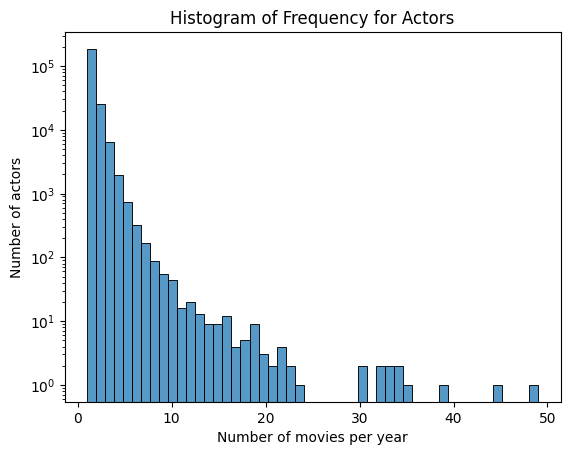

In [53]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')
sns.histplot(frequency_df['movie_count'], bins = 50, log = True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies per year")
plt.title('Histogram of Frequency for Actors')
plt.show()

We can find several outliers that appears a lot. Let's focus on who they are : 

In [54]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)
top5_frequency = frequency_max.head(5)
print(top5_frequency)

             actor_name  release_date  movie_count
180202  Roscoe Arbuckle        1914.0           49
156501     Oliver Hardy        1916.0           45
76332      Harold Lloyd        1919.0           39
180201  Roscoe Arbuckle        1913.0           35
32608   Charlie Chaplin        1914.0           34


In fact, these actors mainly acted (during these years 1910s) in short movies so it might be biased during this period. One solution would be to consider them by period, which we will try to model later on. Another one could be to focus on the mean frequency over all the years : 

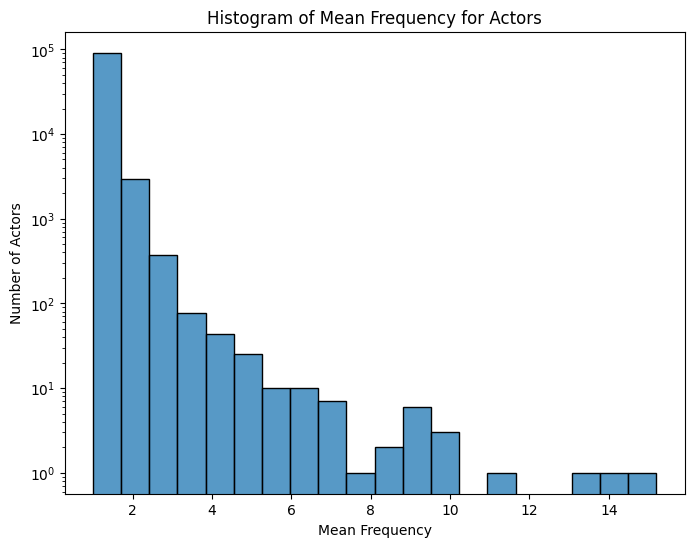

In [55]:
mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')

plt.figure(figsize=(8, 6))
sns.histplot(mean_frequency['mean_frequency'], bins=20,log = True, kde=False)
plt.xlabel('Mean Frequency')
plt.ylabel('Number of Actors')
plt.title('Histogram of Mean Frequency for Actors')
plt.show()

In [56]:
top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print(top5_actors_mf)

             actor_name  mean_frequency
14425  Charlotte Burton            15.2
54785     Louise Lester            14.0
37143        Jack Davis            13.5
90908       Vivian Rich            11.2
13107    Caroline Cooke            10.0


When we search for all these actors, we can see that they are all from the beginning of the movie industry (1910s, early 1920s) when the movies were quite short and silent, so the artistic approach was way more simplified as today. In fact, Roscoe Arbuckle worked as the same time as an actor, a screenwriter and a producer. 

By highlighting that, we could assess that taking into account the period at which the movies were produced is critical. 

So, we tried to filter by period( NB : before 1908, a lot of Nan values occurs so we just filtered) :

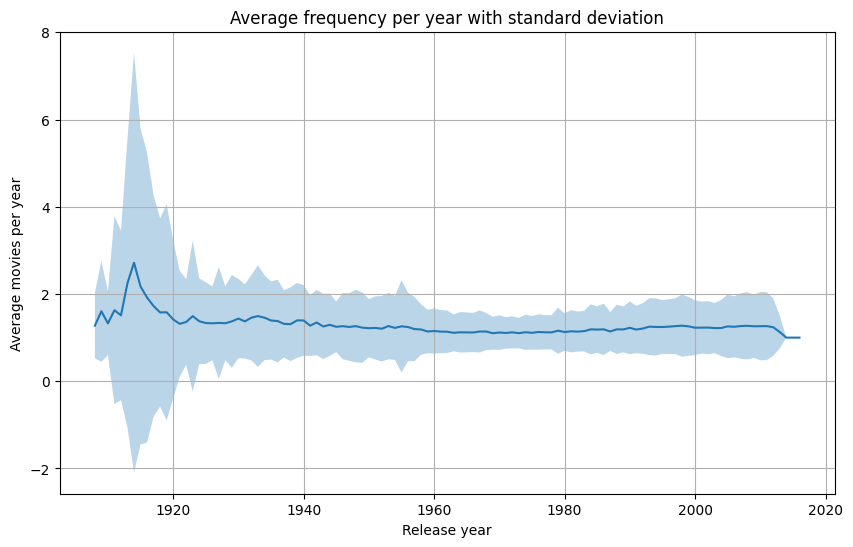

In [58]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']

average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average frequency per year with standard deviation')
plt.grid(True)
plt.show()

Overall, the frequency seems to be constant over the years so it might be a critical features in our final. 

### Career span 

The second axis might be to study the career span of actors and find insights about that :

Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


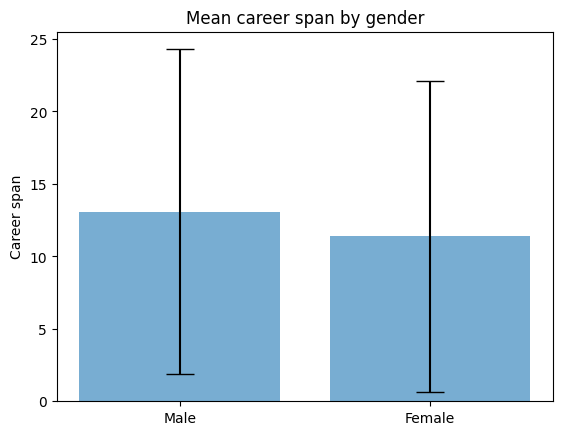

In [59]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_span['career_span'] = (actor_span['max'] - actor_span['min']).dt.days / 365

# Avoid anomalies due to missing values (NaT)
span_thresh = 50 
actor_span = actor_span[(actor_span['career_span'] != 0) & (actor_span['career_span'] < span_thresh)]
actor_career_span = actor_span.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])

male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

# Calculate mean career span for male and female actors and std and plot with confidence intervals
mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female], yerr=[std_career_span_male, std_career_span_female], align='center', alpha=0.6, ecolor='black', capsize=10)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')

plt.show()

One could infer that there is no significant difference between male and female (a first glimpse at this feature might reveal interesting stuff to consider later). Let's run a t-test to verify it : 

In [60]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


We can assess that there is strong evidence about the difference between male and female actors. 

### Total number of movies 

The final axis of the longevity analysis will be the most explicit one : total number of movies throughout career. 

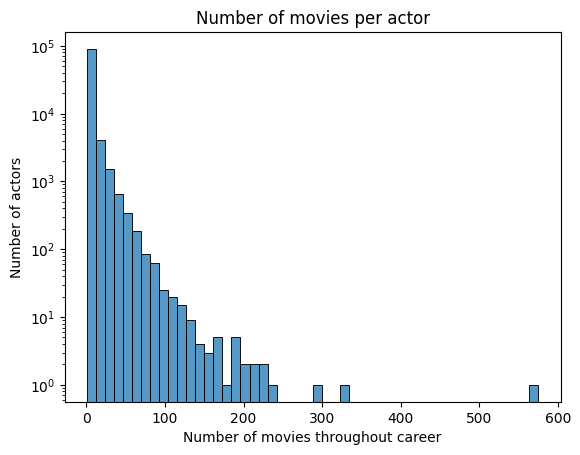

In [62]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')

sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

Here again we can find a particular outlier : more than 500 movies ! Let's find out where that comes from : 

In [63]:
sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

               actor_name gender  total_movie_count
62041           Mel Blanc      M                575
64910  Mithun Chakraborty      M                328
69057        Oliver Hardy      M                299
65110            Mohanlal      M                234
57406           Mammootty      M                225


The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally and by period too, because the leaderboard is exclusively from America in the early ages of cinema and from India nowadays for example.

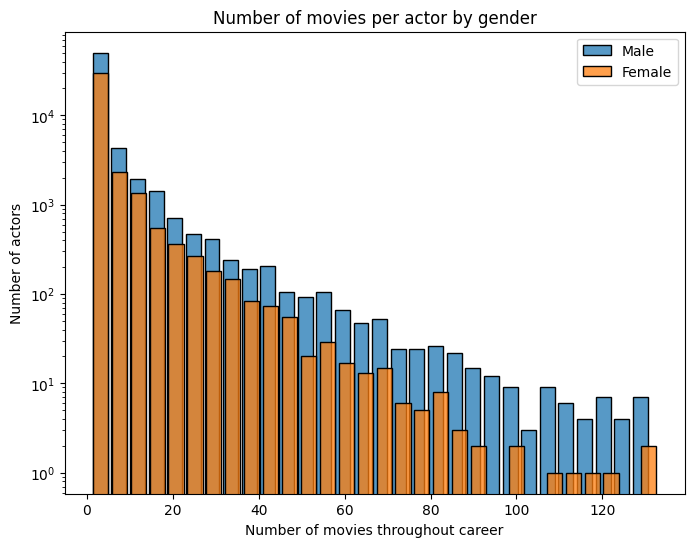

In [64]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

# Plotting separate histograms for men and women with filtered data
plt.figure(figsize=(8, 6))
sns.histplot(male_filtered['total_movie_count'], bins=30, label='Male', log=True, multiple="dodge", shrink=.8)
sns.histplot(female_filtered['total_movie_count'], bins=30, label='Female', log=True, multiple="dodge", shrink=.8)

plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor by gender")
plt.legend()
plt.show()

Overall, it is clear that women tend to do fewer movies than men. We will delve intop this aspect for P3 to find more relevant analysis.

### Combination of all the factors

First we can try a first regression between the two main longevity axis : 

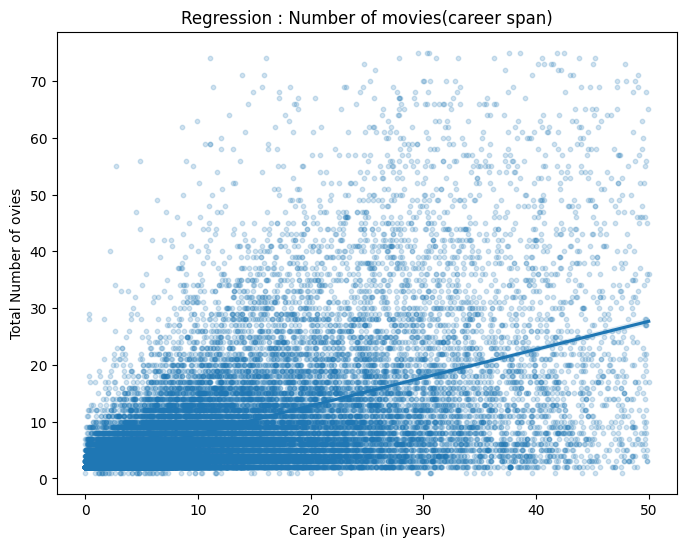

In [68]:
merged_data = pd.merge(actor_span, actor_nb_movie, on='actor_name', how='inner')

# Remove outliers for better visualization
thresh = 75
merged_data = merged_data[merged_data['total_movie_count'] <=  thresh]

# Perform a regression
plt.figure(figsize=(8, 6))
sns.regplot(x='career_span', y='total_movie_count', data=merged_data, scatter_kws={"s": 10, "alpha": 0.2})
plt.xlabel("Career Span (in years)")
plt.ylabel("Total Number of ovies")
plt.title("Regression : Number of movies(career span)")
plt.show()

An obvious observation could be that number of movies increases with career span. But it can be different between regions, gender and history. 

To generalize our study, we can do the pairplot of the three features : 

              actor_name  movies_per_actor  career_span  mean_frequency
0       Cesarine Prinz\t               2.0     4.238356             1.0
2   'Big Bill' Giddinger               1.0     8.438356             1.0
25  A. Edward Sutherland               1.0    14.378082             2.0
36           A. Kanayeva               1.0    11.150685             1.0
45            A. Smirnov               1.0     6.728767             1.0


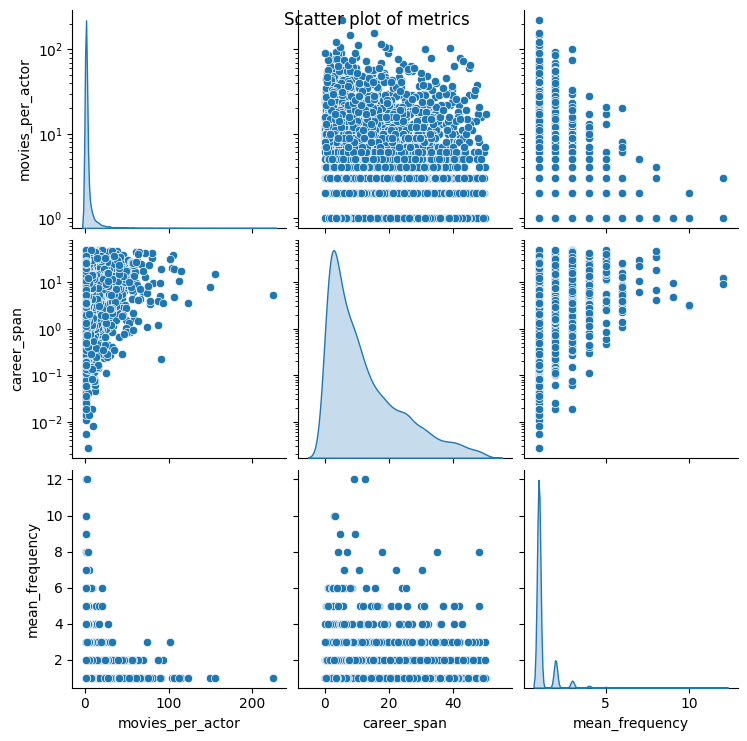

In [71]:
actor_metrics = pd.DataFrame({
    'actor_name': actor_nb_movie['actor_name'],
    'movies_per_actor': actor_nb_movie['total_movie_count'],
    'career_span': actor_career_span['career_span'],  
    'mean_frequency': frequency_df['movie_count'],
})

actor_metrics = actor_metrics.dropna()  

print(actor_metrics.head())
g = sns.pairplot(actor_metrics, diag_kind='kde')

for i in range(g.axes.shape[0] - 1):
    for j in range(g.axes.shape[1] - 1):
        ax = g.axes[i, j]
        if i == j:
            ax.set_yscale('log')

plt.suptitle('Scatter plot of metrics')
plt.show()

A further analysis will allow us to find insights between thesse 3 features, and one more time : adapt our approach between gender, historical and geographical informations. 

In [72]:
###Partie suivante 

## 3. Expected outcomes

We aim to provide a more nuanced understanding of the driving factors of success and allow our reader to interact with our results. The outcomes we want to show include:

- Prediction of all types of success based on a feature input. This can be visualized for instance with a spider chart.
- Identification of important features for a given success indicator goal. This will highlight the power one has in being successful.
- Computation of success indicators for actors present in the dataset. This can be visualized with a research tool. 